In [1]:
using DataFrames, Optim, Revise, Serialization, DebuggingUtilities
using Plots

In [2]:
const datadir = "/export/storage_adgandhi/MiscLi/factract";
string(@__DIR__) in LOAD_PATH || push!(LOAD_PATH, @__DIR__);
using BLPmodule; const m = BLPmodule;

In [3]:
# df = deserialize("jls/df.jls");

testmodes = ["full", "fl", "fl17"]
testmode = testmodes[3]################# EDIT THIS ##################

pars = deserialize("jls/pars.jls");
ec = deserialize("$datadir/analysis/ec$testmode.jls");

---

In [5]:
# linear characteristics (staffing variables):
X1 = vcat(transpose.([ec.firms[i].X for i in eachindex(ec.firms)])...);
Z = vcat(transpose.([ec.firms[i].Z for i in eachindex(ec.firms)])...);

In [76]:
# gmm
pars = deserialize("jls/pars.jls");
ec = deserialize("$datadir/analysis/ec$testmode.jls");
obj_test = m.gmm_lm([1.], ec, pars, X1, hcat(X1,Z));
println(obj_test)


599.2416301890906


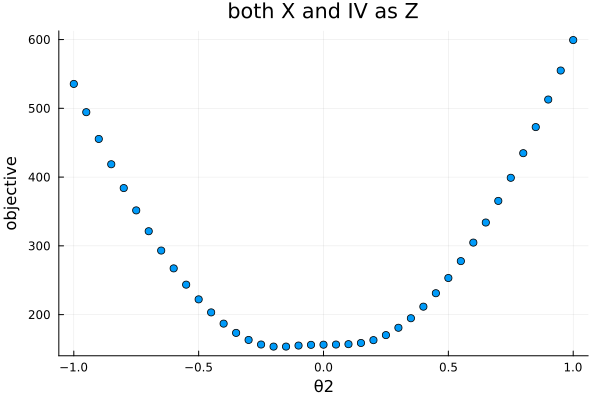

In [99]:
thetas = []
objectives = []
for theta in range(-1., 1., step = 0.05)
    push!(thetas, theta)
    push!(objectives, m.gmm_lm([theta], ec, pars, X1, hcat(X1,Z)))
end
scatter(thetas, objectives, title = "both X and IV as Z", legend = false, xlabel = "θ2", ylabel = "objective")

In [100]:
println(thetas[objectives.==minimum(objectives)])

Any[-0.2]


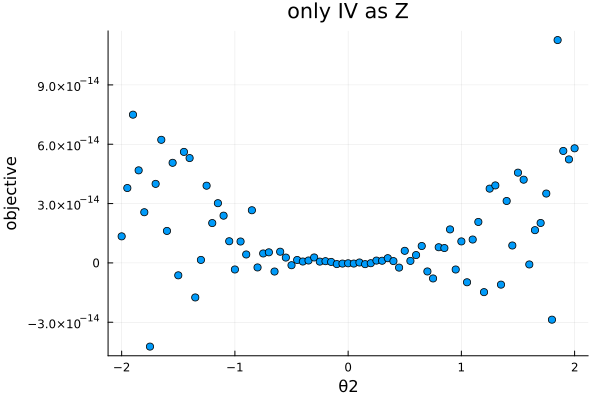

In [63]:
pts = []
for theta in range(-2., 2., step = 0.05)
    push!(pts, (theta, m.gmm_lm([theta], ec, pars, X1, Z)))
end

scatter([p[1] for p in pts], [p[2] for p in pts], title = "only IV as Z", legend = false, xlabel = "θ2", ylabel = "objective")

---

---

In [6]:
# closure 
function closure_gmm(θ2)
    return m.gmm_lm(θ2, deserialize("$datadir/analysis/ec$testmode.jls"), deserialize("jls/pars.jls"), X1, hcat(Z,X1))
end

closure_gmm (generic function with 1 method)

In [10]:
# optim with finite diff
initial_θ2 = [1.]
res = optimize(closure_gmm, initial_θ2, LBFGS(), Optim.Options(show_trace = true))

counter = 1
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 2
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 3
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 4
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 5
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 6
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 7
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 8
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 9
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 10
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 11
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 12
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 13
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 14
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 15
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 16
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 17
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 18
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 19
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 20
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 21
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 22
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 23
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 24
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 25
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 26
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 27
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 28
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 29
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 30
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 31
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 32
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 33
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 34
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 35
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 36
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 37
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 38
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 39
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 40
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 41
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 42
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 43
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 44
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 45
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 46
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 47
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 48
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 49
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 50
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 51
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 52
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 53
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 54
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 55
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 56
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 57
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 58
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 59
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 60
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 61
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 62
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 63
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 64
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 65
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 66
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 67
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 68
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 69
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 70
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 71
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 72
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 73
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 74
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 75
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 76
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 77
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 78
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 79
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 80
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 81
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 82
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 83
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 84
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 85
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 86
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 87
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 88
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 89
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 90
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 91
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 92
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 93
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 94
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 95
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 96
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 97
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 98
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 99
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 100
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 101
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 102
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 103
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 104
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 105
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 106
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 107
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 108
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 109
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 110
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 111
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 112
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 113
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 114
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 115
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 116
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 117
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 118
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 119
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 120
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 121
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 122
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 123
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 124
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 125
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 126
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 127
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 128
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 129
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 130
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 131
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 132
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 133
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 134
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 135
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 136
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 137
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 138
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 139
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 140
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 141
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 142
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 143
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 144
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 145
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 146
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 147
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 148
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 149
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 150
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 151
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 152
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 153
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 154
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 155
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 156
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 157
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 158
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 159
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 160
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 161
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 162
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 163
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


counter = 164
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)



signal (15): Terminated
in expression starting at /mnt/staff/zhli/blp-quantities/gmm.ipynb:3
pthread_cond_wait at /lib64/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:508


counter = 165
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2419
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1703 [inlined]
jl_finish_task at /buildworker/worker/package_linux64/build/src/task.c:208
jl_threadfun at /buildworker/worker/package_linux64/build/src/partr.c:264
start_thread at /lib64/libpthread.so.0 (unknown line)
clone at /lib64/libc.so.6 (unknown line)
unknown function (ip: (nil))
pthread_cond_wait at /lib64/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:508
poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/

counter = 166
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2419
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1703 [inlined]
jl_finish_task at /buildworker/worker/package_linux64/build/src/task.c:208
jl_threadfun at /buildworker/worker/package_linux64/build/src/partr.c:264
start_thread at /lib64/libpthread.so.0 (unknown line)
clone at /lib64/libc.so.6 (unknown line)
unknown function (ip: (nil))
pthread_cond_wait at /lib64/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:508
poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/

counter = 167
(in /mnt/staff/zhli/blp-quantities/BLPmodule/solve.jl:88)


wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2419
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1703 [inlined]
jl_finish_task at /buildworker/worker/package_linux64/build/src/task.c:208
jl_threadfun at /buildworker/worker/package_linux64/build/src/partr.c:264
start_thread at /lib64/libpthread.so.0 (unknown line)
clone at /lib64/libc.so.6 (unknown line)
unknown function (ip: (nil))
pthread_cond_wait at /lib64/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:508
poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/bu

poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2419
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1703 [inlined]
jl_finish_task at /buildworker/worker/package_linux64/build/src/task.c:208
jl_threadfun at /buildworker/worker/package_linux64/build/src/partr.c:264
start_thread at /lib64/libpthread.so.0 (unknown line)
clone at /lib64/libc.so.6 (unknown line)
unknown function (ip: (nil))
pthread_cond_wait at /lib64/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:508
poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/

In [ ]:
Optim.minimizer(res)

In [ ]:
Optim.minimum(res)

---

In [12]:
# one dimensional first

---